In [5]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [6]:
# Custom dataset class for loading images and masks
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        # Initialize with directories and transform
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        # Get sorted list of image and mask files
        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))

    def __len__(self):
        # Return the total number of samples
        return len(self.images)

    def __getitem__(self, idx):
        # Get the image and mask file paths
        image_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        # Load the image and mask
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Convert mask to tensor and ensure it's of long type
        mask = torch.tensor(np.array(mask), dtype=torch.long)
        return image, mask


In [8]:
# Define the U-Net model architecture
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        # Define a function to create a block of two convolutional layers
        def conv_block(in_channels, out_channels):
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            return block

        # Define a function to create an upsampling layer
        def up_conv(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        # Create encoder layers
        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)
        
        # Create bottleneck layer
        self.bottleneck = conv_block(512, 1024)
        
        # Create decoder layers
        self.upconv4 = up_conv(1024, 512)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = up_conv(512, 256)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = up_conv(256, 128)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = up_conv(128, 64)
        self.decoder1 = conv_block(128, 64)
        
        # Final convolutional layer to produce output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Forward pass through encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(nn.MaxPool2d(2)(enc1))
        enc3 = self.encoder3(nn.MaxPool2d(2)(enc2))
        enc4 = self.encoder4(nn.MaxPool2d(2)(enc3))
        
        # Forward pass through bottleneck
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))
        
        # Forward pass through decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        # Output layer
        return self.final_conv(dec1)


In [9]:
# Initialize the model, loss function, and optimizer
num_classes = 2  # Background and rock
model = UNet(in_channels=3, out_channels=num_classes)

# CrossEntropyLoss is commonly used for multi-class classification problems
criterion = nn.CrossEntropyLoss()

# Adam optimizer is widely used due to its adaptive learning rate properties
# Other optimizers that can be tried are SGD, RMSprop, etc.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Check if a GPU is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

In [10]:
# Function to train the model
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            for inputs, masks in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                masks = masks.to(device).squeeze(1)  # Remove the extra dimension

                # Zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            # Calculate epoch loss
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f}')

    print('Training complete')


In [11]:
# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize image to 128x128
    transforms.ToTensor()
])

# Create the datasets
train_dataset = SegmentationDataset(images_dir='data/train/images', masks_dir='data/train/masks', transform=transform)
val_dataset = SegmentationDataset(images_dir='data/val/images', masks_dir='data/val/masks', transform=transform)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)  # Batch size can be adjusted based on memory
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Create a dictionary of dataloaders
dataloaders = {
    'train': train_loader,
    'val': val_loader
}


In [12]:
# Train the model
train_model(model, dataloaders, criterion, optimizer, num_epochs=10)  # Number of epochs can be adjusted


Epoch 1/10
----------


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.10it/s]


train Loss: 0.5900


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.46it/s]


val Loss: 0.6830
Epoch 2/10
----------


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.83it/s]


train Loss: 0.4955


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.92it/s]


val Loss: 0.6669
Epoch 3/10
----------


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.08it/s]


train Loss: 0.4164


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.64it/s]


val Loss: 0.6354
Epoch 4/10
----------


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.15it/s]


train Loss: 0.3353


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.98it/s]


val Loss: 0.5931
Epoch 5/10
----------


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.45it/s]


train Loss: 0.2823


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.50it/s]


val Loss: 0.5329
Epoch 6/10
----------


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.86it/s]


train Loss: 0.2493


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.41it/s]


val Loss: 0.5289
Epoch 7/10
----------


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.05it/s]


train Loss: 0.2159


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.03it/s]


val Loss: 0.5275
Epoch 8/10
----------


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.06it/s]


train Loss: 0.1918


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.42it/s]


val Loss: 0.5888
Epoch 9/10
----------


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.38it/s]


train Loss: 0.1726


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.92it/s]


val Loss: 0.5380
Epoch 10/10
----------


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.03it/s]


train Loss: 0.1603


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.42it/s]

val Loss: 0.4349
Training complete


In [13]:
# Save the model
torch.save(model.state_dict(), '')


In [14]:
# Function to run inference on a single image and save the mask
def run_inference(model, image_path, transform, save_path=None):
    model.eval()  # Set model to evaluate mode
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    input_tensor = input_tensor.to(device)
    
    with torch.no_grad():
        # Forward pass
        output = model(input_tensor)
    predicted_mask = torch.argmax(output, dim=1).squeeze(0)  # Get predicted mask
    
    # Save the predicted mask if save_path is provided
    if save_path:
        predicted_mask_image = Image.fromarray(predicted_mask.cpu().numpy().astype(np.uint8) * 255)  # Convert to binary image
        predicted_mask_image.save(save_path)
    
    return predicted_mask.cpu().numpy(), np.array(image)

# Run inference on an image from the validation dataset and save the mask
val_image_path = 'data/val/images/4.jpeg'
predicted_mask, original_image = run_inference(model, val_image_path, transform, save_path='predicted_mask.png')


In [15]:
!ls

cuda_12.2.2_535.104.05_linux.run  predicted_mask.png
cuda-keyring_1.1-1_all.deb	  readme_nvidia_driver.txt
cuda-keyring_1.1-1_all.deb.1	  rocks_coco_dataset
data				  rocks_dataset_seg_mask
env_test.ipynb			  unet_model.ipynb
model_deeplab_v3.ipynb		  unet_model.pth


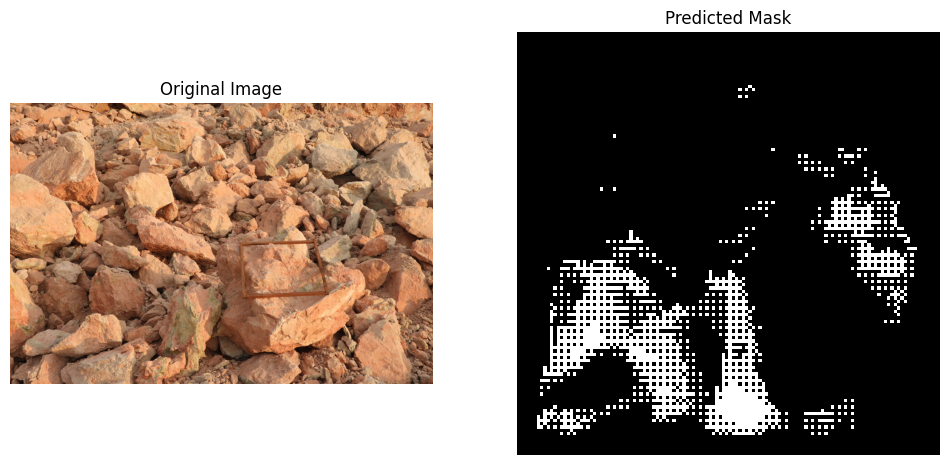

In [16]:
# Display the original image and the predicted mask
plt.figure(figsize=(12, 6))

# Display the original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image)
plt.axis('off')

# Display the predicted mask
plt.subplot(1, 2, 2)
plt.title('Predicted Mask')
plt.imshow(predicted_mask, cmap='gray')
plt.axis('off')

plt.show()

In [21]:
# perform inference on an image, overlay the predicted mask on the original image, and save the result.

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Define the UNet model architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = self.conv_block(3, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        self.bottleneck = self.conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, 2, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(nn.MaxPool2d(kernel_size=2, stride=2)(enc1))
        enc3 = self.encoder3(nn.MaxPool2d(kernel_size=2, stride=2)(enc2))
        enc4 = self.encoder4(nn.MaxPool2d(kernel_size=2, stride=2)(enc3))

        bottleneck = self.bottleneck(nn.MaxPool2d(kernel_size=2, stride=2)(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.final_conv(dec1)

# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('unet_model.pth', map_location=device))

# Set the model to evaluation mode
model.eval()

# Define the transformation for the input image
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match model input
    transforms.ToTensor(),  # Convert PIL Image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats
])

# Function to run inference and save the overlayed image
def run_inference_and_save_overlay(model, image_path, transform, device, save_path):
    # Load the image
    image = Image.open(image_path).convert("RGB")
    
    # Apply the transformations to the image
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    input_tensor = input_tensor.to(device)
    
    with torch.no_grad():
        # Perform the forward pass
        output = model(input_tensor)
    
    # Get the predicted mask by taking the argmax over the class dimension
    predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    
    # Convert the predicted mask to a binary mask (0 or 255)
    mask = (predicted_mask > 0).astype(np.uint8) * 255  # Assuming class 1 is the target class
    
    # Resize the mask to the original image size
    mask_image = Image.fromarray(mask).resize(image.size, Image.NEAREST)
    mask = np.array(mask_image)
    
    # Overlay the mask on the original image
    overlayed_image = np.array(image)
    colored_mask = np.zeros_like(overlayed_image)
    colored_mask[mask == 255] = [255, 0, 0]  # Red color for detected areas
    
    # Blend the original image and the colored mask
    alpha = 0.5
    overlayed_image = Image.fromarray((alpha * overlayed_image + (1 - alpha) * colored_mask).astype(np.uint8))
    
    # Save the overlayed image if a save path is provided
    if save_path:
        overlayed_image.save(save_path)
    
    return overlayed_image

# Path to the image for inference
image_path = 'data/val/images/4.jpeg'  # Change this to your validation image path

# Path to save the overlayed image
save_path = 'overlayed_image.png'  # Change this to your desired save path

# Run inference and save the overlayed image
overlayed_image = run_inference_and_save_overlay(model, image_path, transform, device, save_path)

# Display the overlayed image
overlayed_image.show()
